# Generating player profiles

To simulate our tournament, let us first generate "player profiles". I will use the ELO system to determine
the relative probability to win of each player. I ll use the common chess interpretation for this (although assuming a smaller gap between the very best players and the average ones). So an ELO of 1000 is used for a beginner, an average player has an ELO around 1200-1400, your local club champion is around 1800-2000, and I'll arbitrary assume our national masters are around 2200. Clearly, as for all arbitrary decisions in this discussion, this can potentially be the subject of debates but hopefully we will obtain similar patterns while varying these parameters.

I ll consider a 32 player tournaments, which nicely converges to a maximum of one player with five wins if winners only play against winners, in which case ideally this player should be the winner (we will see that unfortunately this is NOT the case for most systems).


In [1]:
N_PLAYERS = 32
MIN_ELO = 1000
MAX_ELO = 2200
AVG_ELO = 1400

## Probability of Winning Based on ELO Ratings

What does it mean to have a certain ELO rating? 
For two players, Player A and Player B, with ELO ratings $( R_A )$ and $( R_B )$ respectively, the expected score (probability of winning) for player A can be calculated using the following formulas:

$$ E_A = \frac{1}{1 + 10^{(R_B - R_A) / 400}} $$

So what are the chances of a  local club champion to beat a national master?
let's see:

In [2]:
def win_probability(rating_a, rating_b):
    """
    Compute the probability of Player A winning against Player B based on their Elo ratings.
    
    Parameters:
    rating_a (float): Elo rating of Player A.
    rating_b (float): Elo rating of Player B.
    
    Returns:
    float: Probability of Player A winning.
    """
    prob_a = 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    
    return prob_a


rating_a = 1750
rating_b = 2200

prob_a = win_probability(rating_a, rating_b)

print(f"Probability of Player A winning: {prob_a * 100.:.1f}%")
print(f"Probability of Player B winning: {100*(1.-prob_a):.1f}%")

Probability of Player A winning: 7.0%
Probability of Player B winning: 93.0%


What about a very good local club champion vs a top player ?

In [3]:
rating_a = 2000
rating_b = 2200

prob_a = win_probability(rating_a, rating_b)

print(f"Probability of Player A winning: {prob_a * 100.:.1f}%")
print(f"Probability of Player B winning: {100*(1.-prob_a):.1f}%")

Probability of Player A winning: 24.0%
Probability of Player B winning: 76.0%


Let us also check that two equivalent players have similar chances of winning

In [4]:
rating_a = 1300
rating_b = 1300

prob_a = win_probability(rating_a, rating_b)

print(f"Probability of Player A winning: {prob_a * 100.:.1f}%")
print(f"Probability of Player B winning: {100*(1.-prob_a):.1f}%")

Probability of Player A winning: 50.0%
Probability of Player B winning: 50.0%


## Generating 32 players

I will now generate player profiles, with a normal distribution centered around 1400 and plot the resulting ELOs to check that this is somewhat what we expect in terms of player distribution. To check that the distribution is what we expect I ll generate more than 32, say 10000 instead, otherwise the results will not be representative.

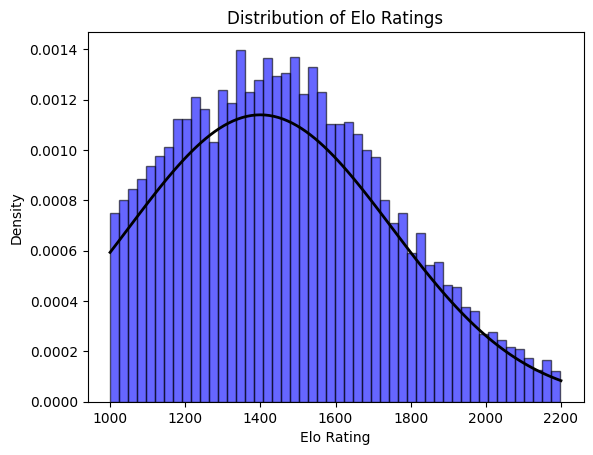

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import truncnorm

std_dev = 350
def generate_normal_elo_ratings(num_ratings=N_PLAYERS, mean=AVG_ELO, std_dev=std_dev, lower_bound=MIN_ELO, upper_bound=MAX_ELO):
    X = truncnorm((lower_bound - mean) / std_dev, (upper_bound - mean) / std_dev, loc=mean, scale=std_dev) 
    return X.rvs(num_ratings)

def plot_ratings(elo_ratings):# Plot the histogram of Elo ratings
    plt.hist(elo_ratings, bins=50, density=True, alpha=0.6, color='b', edgecolor='black')

    # Plot the normal distribution curve
    xmin, xmax = 1000, 2200
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, AVG_ELO, std_dev)
    plt.plot(x, p, 'k', linewidth=2)

    # Add titles and labels
    plt.title('Distribution of Elo Ratings')
    plt.xlabel('Elo Rating')
    plt.ylabel('Density')

    # Show the plot
    plt.show()

elo_ratings = generate_normal_elo_ratings(num_ratings=10000)
plot_ratings(elo_ratings)



Ok, it looks like our code runs correctly. In average our players have an ELO of 1400 and only a minority will be among the very top. To generate a set of player profiles I can now simply call:

In [6]:
player_profiles = generate_normal_elo_ratings()


Let's plot an example of player profiles for one tournament, sorted by their theoretical ELOs.

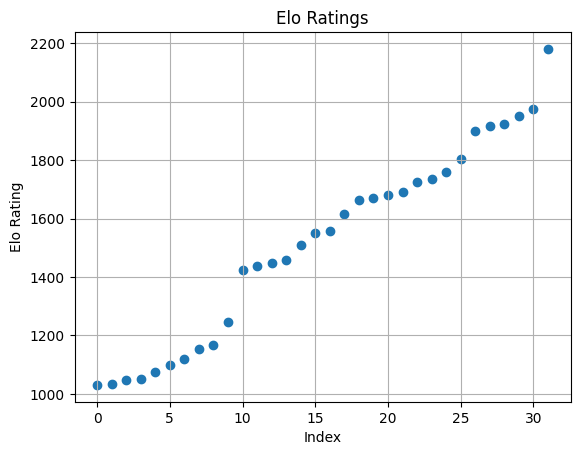

In [7]:
player_profiles = sorted(generate_normal_elo_ratings())
indices = list(range(len(player_profiles)))
plt.scatter(indices, player_profiles)
plt.title('Elo Ratings')
plt.xlabel('Index')
plt.ylabel('Elo Rating')
plt.grid(True)
plt.show()

In this event there are a few beginners, a good distribution of average players, few local champions and one contendent for the Uk masters! In our tests we will run several instances of tournaments under different systems to obtain a comparison of the outcomes as fair as possible

# Simulating a game.

To play a game, we already know the probability for a player A to win against player B, but this is insufficient to determine the outcome of a KOW game according to the main scoring systems. Indeed, we need to consider draws, Kill points and scenario points.

## Win, Loss or draw ? 
The ELO system does not allow to predict draws directly. However, we can use an empirical distribution which, given the $E_A$ score, tells us the probability of winning / drawing or losing. I ll use the following table, arbitrarily assuming that 2 players with the same level will have 20% chances of drawing:

| E[score] | P(win) | P(draw) | P(lose) |
|----------|--------|---------|---------|
| 0.0      | 0.00   | 0.00    | 1.00    |
| 0.1      | 0.09   | 0.02    | 0.89    |
| 0.2      | 0.17   | 0.06    | 0.77    |
| 0.3      | 0.24   | 0.12    | 0.64    |
| 0.4      | 0.31   | 0.18    | 0.51    |
| 0.5      | 0.40   | 0.20    | 0.40    |
| 0.6      | 0.51   | 0.18    | 0.31    |
| 0.7      | 0.64   | 0.12    | 0.24    |
| 0.8      | 0.77   | 0.06    | 0.17    |
| 0.9      | 0.89   | 0.02    | 0.09    |
| 1.0      | 1.00   | 0.00    | 0.00    |

Using this table, we can "play" a game between two players and determine the outcome. I ll first interpolate the discrete values of the table to obtain a continuous definition of the probabilities:


In [8]:
Es = [(float(i) * 0.1) for i in range (11)]
def interpolate(data):
    coeffs = np.polyfit(Es, data, 4)
    poly_func = np.poly1d(coeffs)
    return poly_func


win_data  = [0. ,0.09,0.17,0.24,0.31,0.40,0.51,0.64,0.77,0.89,1.0]
draw_data = [0. ,0.02,0.06,0.12,0.18,0.20,0.18,0.12,0.06,0.02,0.0]
loss_data = win_data[:]; loss_data.reverse()
loss_data
p_win  = interpolate(win_data) 
p_draw = interpolate(draw_data) 
p_loss = interpolate(loss_data) 
   

Let's plot our functions to check we are all good:

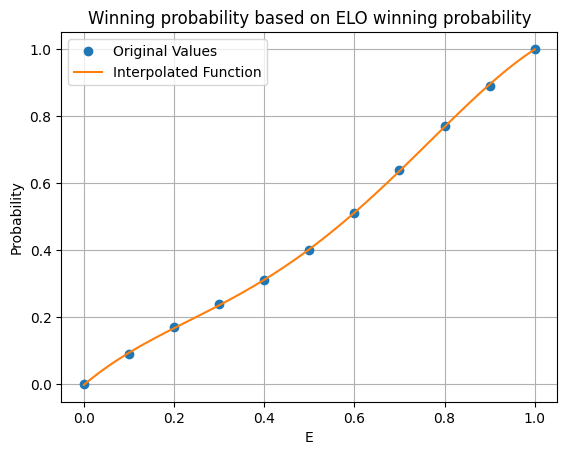

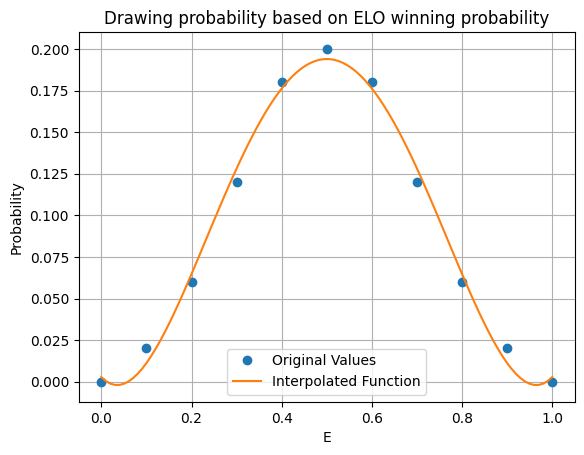

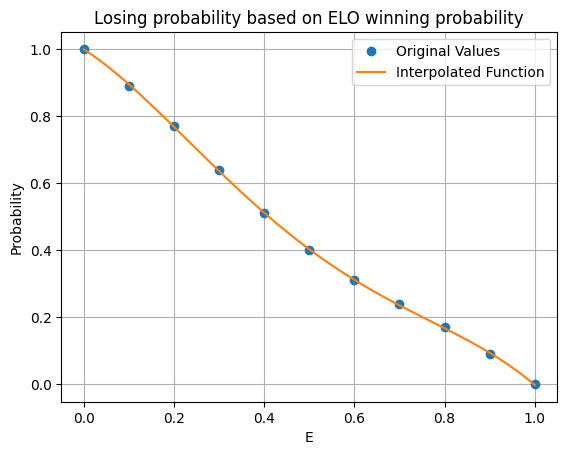

In [9]:
def plot_interpolation(x_values, y_values, interp_x_values, interp_y_values, title):
    """
    Plot the original values and the interpolated function.
    
    Parameters:
    x_values (list or array): List of original x values.
    y_values (list or array): List of original y values.
    interp_x_values (array): Interpolated x values.
    interp_y_values (array): Interpolated y values.
    """
    plt.plot(x_values, y_values, 'o', label='Original Values')
    plt.plot(interp_x_values, interp_y_values, '-', label='Interpolated Function')
    plt.xlabel('E')
    plt.ylabel('Probability')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    
interp_x_values = np.linspace(min(Es), max(Es), 100)
interp_y_values = p_win(interp_x_values)
plot_interpolation(Es, win_data, interp_x_values, interp_y_values, "Winning probability based on ELO winning probability")

interp_x_values = np.linspace(min(Es), max(Es), 100)
interp_y_values = p_draw(interp_x_values)
plot_interpolation(Es, draw_data, interp_x_values, interp_y_values, "Drawing probability based on ELO winning probability")

interp_x_values = np.linspace(min(Es), max(Es), 100)
interp_y_values = p_loss(interp_x_values)
plot_interpolation(Es, loss_data, interp_x_values, interp_y_values, "Losing probability based on ELO winning probability")


I m allowing myself a few approximations here, because the sum of probabilities is only "roughly" equal to 1 (and also the drawing interpolation can give negative probabilities, but we will just assume they are 0 in the method proposed right after). While statisticians are probably dying at this point, I am pretty sure this is enough for our project, as long as the game resolution accounts for this. I will now write a function that given two ELO ratings, returns whether the outcome is a win, a draw or a loss for player A. For this I ll randomly generate a number between 0 and 1. If that number is lower or equal than the losing probability, then player A will have lost. If not and the number is lower or equal than the losing + drawing probability, then the result is a draw. Otherwise, player A will have won. 

We will return 1 for a loss, 2 for a draw, and 3 for a win

In [10]:
from numpy import random
def play_match(rating_a, rating_b):
    """
    Determine the outcome of a match between player A and B
    
    Parameters:
    rating_a (float): Elo rating of Player A.
    rating_b (float): Elo rating of Player B.
    
    Returns:
    int: 1, 2 or 3 respectively if player A lost, drew or won
    """
    prob_a = win_probability(rating_a, rating_b)
    roll = random.uniform(0, 1)
    if roll <= p_loss(prob_a):
        return 1
    elif roll <= p_loss(prob_a) + p_draw(prob_a):
        return 2
    else:
        return 3
    
    


As always let's check that the outcome is what we expect somehow

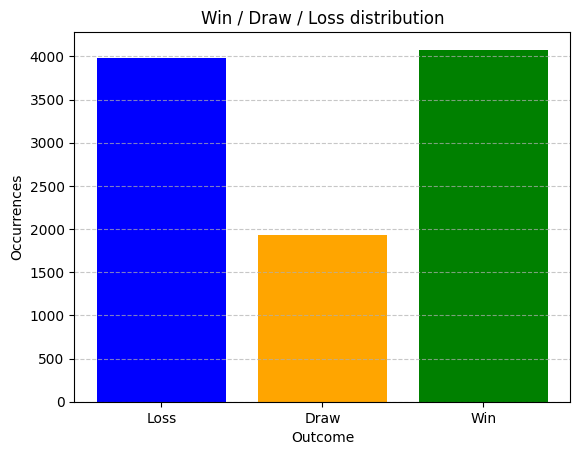

In [11]:
int_list = [play_match(1500, 1500) for _ in range (10000)]
occurrences = [int_list.count(1), int_list.count(2), int_list.count(3)]
    
# Integer labels
integers = ["Loss", "Draw", "Win"]
    
# Plotting
plt.bar(integers, occurrences, color=['blue', 'orange', 'green'])
plt.xlabel('Outcome')
plt.ylabel('Occurrences')
plt.title('Win / Draw / Loss distribution')
plt.xticks(integers)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## How big is a win / loss ?
Depending on the scoring system, a big win or loss has a different meaning in terms of KP / VP etc. So for now, we will simply attribute a score between 0 and 1 that says how "good" was the win/ the draw / the loss. A score of 1 means that the player should score the maximum number of points while a score or 0 means that the victory is the minimum possible. In the outcome, there will be one such number per player as for instance in the Northern Kings scoring system you can lose but kill most of the opponent army. These two numbers will later be interpreted by the scoring system to output a viable outcome.

I chose to link the probability of a "big" win to the actual probability of winning, by centering the distribution of the sample around it. For instance if you have a probability of winning of 80% the winning score is likely to be around 0.8, although a score of 0 remains possible but less likely. Let us reimplement the ```play_match``` function accordingly. Instead of outputting only a result, it also outputs 2 additional numbers who represents the score of each player

In [15]:
from numpy import random

def biased_draw(mean, std_dev = 0.1):
    X = truncnorm((0. - mean) / std_dev, (1. - mean) / std_dev, loc=mean, scale=std_dev)
    return X.rvs()


def play_match(rating_a, rating_b):
    """
    Determine the outcome of a match between player A and B
    
    Parameters:
    rating_a (float): Elo rating of Player A.
    rating_b (float): Elo rating of Player B.
    
    Returns:
    a triplet:
        int: 1, 2 or 3 respectively if player A lost, drew or won
        float: a [0,1] float indicative of how many points should the player A receive 
        float: a [0,1] float indicative of how many points should the player B receive 
    """
    prob_a = win_probability(rating_a, rating_b)
    roll = random.uniform(0, 1)
    outcome_number = -1 
    outcome_rate_a = -1.;
    outcome_rate_b = -1.;
    if roll <= p_loss(prob_a):
        outcome_number = 1 #loss        
    elif roll <= p_loss(prob_a) + p_draw(prob_a):
        outcome_number = 2 #draw
    else:
        outcome_number = 3 #win
    outcome_rate_a = biased_draw(p_win(prob_a));
    outcome_rate_b = biased_draw(p_win(1.-prob_a));
    return [outcome_number, outcome_rate_a, outcome_rate_b]
    

Let's just check that this works. Let's have two players with a ELO rating difference of about 240, such that  player A has about 77% chances of winning. Let's have them play N times and check that:
+ overall player A wins 77% of the time
+ Whether he wins, draws or loses, the score is centered around 0.77 
+ Player B's score is centered around 0.17

percentage of wins 76.42999999999999


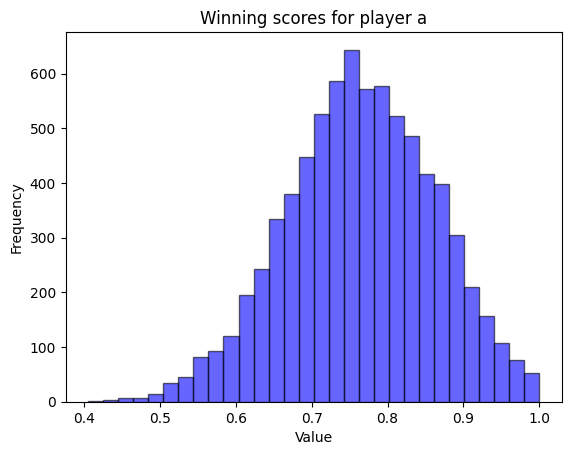

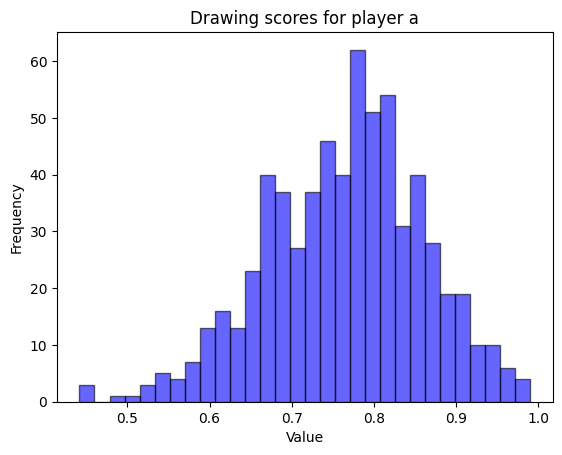

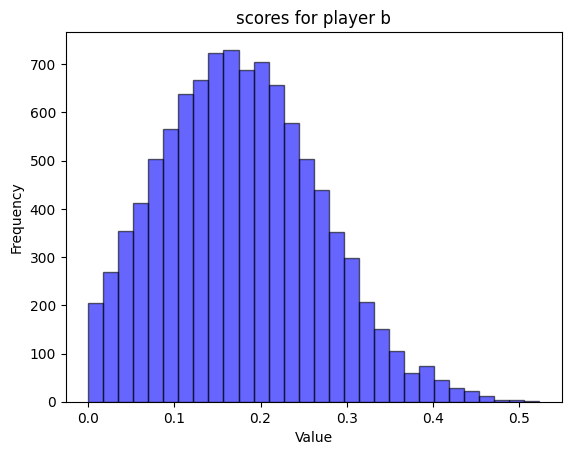

In [16]:
rating_a = 1541
rating_b = 1300
prob_a = win_probability(rating_a, rating_b)
prob_win = p_win(prob_a)

matches = [play_match(rating_a, rating_b) for _ in range(10000)]

wins   = [el for el in matches if el[0] == 3]
losses = [el for el in matches if el[0] == 1]
draws  = [el for el in matches if el[0] == 2]


print ("percentage of wins", len(wins) / len(matches) * 100.)

outcomes_win = [el[1]  for el in wins]
plt.hist(outcomes_win, bins=30, color='blue', alpha=0.6, edgecolor='black')

# Add title and labels
plt.title(f'Winning scores for player a')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

outcomes_losses = [el[1]  for el in losses]
#plt.hist(outcomes_losses, bins=30, color='blue', alpha=0.6, edgecolor='black')

# Add title and labels
#plt.title(f'Losing scores for player a')
#plt.xlabel('Value')
#plt.ylabel('Frequency')

# Show the plot
#plt.show()

outcomes_draws = [el[1]  for el in draws]
plt.hist(outcomes_draws, bins=30, color='blue', alpha=0.6, edgecolor='black')

# Add title and labels
plt.title(f'Drawing scores for player a')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

outcomes_b = [el[2]  for el in matches]
plt.hist(outcomes_b, bins=30, color='blue', alpha=0.6, edgecolor='black')

# Add title and labels
plt.title(f'scores for player b')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()



After all this we now have a single function ```play_match``` that simulates a match between two players based on their ELO score.


# Playing a KOW tournament
We now have a mean of determining who wins. However there are other things that we need to consider if we want to compare scoring systems.

First, we need to compare the systems based on the same outcome for all  possible encounters (which is a problem because the matches played will not be the same depending on the systems).


Secondly, victory / loss / draw is not sufficient as we also need the kill points and the scenario points in most scoring systems. Other criteria might be considered but they are not relevant here in general.

## Generating encounters data
Depending on the system implemented, given the same outcomes different players will play against each other in a tournament. When comparing the system, to make sure that the same outcome is considered we will first simulate all the games possible (ie each player will play each other player). We will actually do this 5 times just to make sure that in the case players play several times against each other we also have these outcomes. (NB: the number of times players encounter each other is also a criteria for evaluating a scoring system). Given all the possible encounters outcome, we will then be able to apply each scoring system to the same data and evaluate the outcome of the tournament.

From now on, each player is identified by its index in the ELO ratings list, between 0 and 31


In [17]:
#we will store all the data into a list of list

def play(elo, opponents):
    return [[play_match(elo, elo_opponent) for _ in range(5)] for elo_opponent in opponents]

def tournament_data(elo_ratings):
    return [play(elo_ratings[i],elo_ratings[i+1:]) for i in range(len(elo_ratings)-1)]
    
        
elo_ratings = generate_normal_elo_ratings(N_PLAYERS)
tournament_matches = tournament_data(elo_ratings)



To retrieve the outcome of a specific match we can write the following function. The ```remove_encounter``` parameter is used to remove the instance of the match and return a new outcome if players are to meet again.


In [18]:
def rev(num):
    if num == 1:
        return 3
    elif num == 3:
        return 1
    return 2

#return outcomes from player A perspective
def match_result(tournament_matches, playerAIndex, playerBIndex, remove_encounter=False):
    minIdx = min(playerAIndex, playerBIndex);
    maxIdx = max(playerAIndex, playerBIndex);
    outcome = tournament_matches[minIdx][maxIdx-1-minIdx][0]
    if playerAIndex > playerBIndex: #reverse outcomes
        outcome =[rev(outcome[0]),outcome[2], outcome[1]]
    if remove_encounter:
        tournament_matches[minIdx][maxIdx-1-minIdx][:] = tournament_matches[minIdx][maxIdx-1-minIdx][1:]
    return outcome        


## "Unrolling" a tournament
A tournament consists in the following steps:

1. randomly assign opponents
2. play all the games for the current round
3. rank the players according to their current score
4. If all the games have been played, go back to step 2. If not, the rank obtained is the final ranking

In our case, step 1 is already solved. Since we randomly assign profiles to the player, we can simply assign matches by progressing towards the list of profiles. We will need to add more information on the player profile though: an Id and a current score. We will also add a history of their encounters as an helper.




In [19]:
class Player:
    def __init__(self, idx, elo):
        self.idx = idx
        self.elo = elo
        self.score = 0
        self.track = []
    def __str__(self):
        return f"Player {self.idx}: Elo={self.elo}, Score={self.score}\n\t, Track{self.track}"
    def __repr__(self):
        return f"Player {self.idx}: Elo={self.elo}, Score={self.score}\n\t, Track{self.track}"

Step 2 is just a matter of retrieving the outcomes which we computed before.

Step 3 is specific to each scoring system, and is the focus of this section.

We can thus easily write a "play_tournament" function that performs all of the steps given an abstract ranking method.
We will write it recursively using the initial player profiles as the initial "ranking"

In [20]:
import copy

def play_tournament(player_elos, matches_results, score_function):
    #first create the players
    players = [Player(i, elo) for (i, elo) in enumerate(player_elos)]
    current_matches = copy.deepcopy(matches_results) 
    current_ranking = copy.deepcopy(players) 
    def play_round(current_round):
        nonlocal current_ranking
        nonlocal players
        nonlocal current_matches
        if current_round == 5: #all rounds have been played
            return current_ranking
        round_outcomes = [match_result(current_matches, current_ranking[i].idx, current_ranking[i+1].idx, remove_encounter=False) for i in range(0, len(current_ranking), 2)]
        scores = [score_function(outcome) for outcome in round_outcomes]
        for i, score in enumerate(scores):
            current_ranking[2*i].score += score[0]
            current_ranking[2*i+1].score += score[1]            
            current_ranking[2*i].track   += [ "player " + str(current_ranking[2*i+1].idx) + ": " + str(round_outcomes[i][0])]
            current_ranking[2*i+1].track += [ "player " + str(current_ranking[2*i  ].idx) + ": " + str(rev(round_outcomes[i][0]))]
        current_ranking = sorted(current_ranking, key=lambda player: -player.score)
        return play_round(current_round+1)
    return play_round(1)
    

Let's test our tournament function with a naive scoring function that simply returns 10 times the outcome number (1, 2 or 3) + the "goodness" of the result

In [21]:
player_elos = generate_normal_elo_ratings(N_PLAYERS); player_elos[0] = 5000
matches_results = tournament_data(player_elos)

In [22]:
def naive_score(result_triplet):
    res1 = result_triplet[0]
    res2 = rev(res1) 
    return [10*res1 + result_triplet[1], 10*res2 + result_triplet[2]]



final_rank = play_tournament(player_elos, matches_results, naive_score)

In [23]:
final_rank


[Player 0: Elo=5000.0, Score=123.83205320100824
 	, Track['player 1: 3', 'player 18: 3', 'player 6: 3', 'player 8: 3'],
 Player 31: Elo=1845.1032042131333, Score=112.80245596741514
 	, Track['player 30: 3', 'player 22: 3', 'player 11: 2', 'player 20: 3'],
 Player 11: Elo=1725.8417282847813, Score=111.63943891195152
 	, Track['player 10: 3', 'player 2: 3', 'player 31: 2', 'player 16: 3'],
 Player 18: Elo=1966.6943243831288, Score=103.06219801046484
 	, Track['player 19: 3', 'player 0: 1', 'player 15: 3', 'player 6: 3'],
 Player 8: Elo=1956.0463780197524, Score=102.4689157009938
 	, Track['player 9: 3', 'player 28: 3', 'player 24: 3', 'player 0: 1'],
 Player 26: Elo=1495.6779481250596, Score=101.64876885495046
 	, Track['player 27: 3', 'player 16: 3', 'player 20: 1', 'player 2: 3'],
 Player 22: Elo=1559.4723370308911, Score=101.57698551559035
 	, Track['player 23: 3', 'player 31: 1', 'player 9: 3', 'player 21: 3'],
 Player 28: Elo=1726.426728093157, Score=92.57175771251612
 	, Track['pla